### Installing Required Libraries
Before starting the analysis, we need to ensure that all necessary libraries are installed.

In [36]:
!pip install scikit-learn --upgrade
!pip install catboost tensorflow
!pip install osmnx
!pip install openrouteservice

### Importing Libraries
The essential libraries for data manipulation, visualization, and modeling are imported.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from catboost import CatBoostRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import joblib
import osmnx as ox
import networkx as nx
import openrouteservice
import requests


### Mounting Google Drive
For data storage and retrieval, Google Drive is mounted.

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Defining File Paths
Paths for various datasets are defined for easier access.

In [39]:
data_paths = {
    "bank_holidays": '/content/drive/MyDrive/datasets/bank_holidays.csv',
    "routes": '/content/drive/MyDrive/datasets/routes.csv',
    "detectors": '/content/drive/MyDrive/datasets/detectors.csv',
    "construction": '/content/drive/MyDrive/datasets/construction.csv',
    "weather": '/content/drive/MyDrive/datasets/weather.csv',
    "traffic_september": '/content/drive/MyDrive/datasets/traffic_2024_09.csv',
    "traffic_october": '/content/drive/MyDrive/datasets/traffic_2024_10.csv',
    "traffic_november": '/content/drive/MyDrive/datasets/traffic_2024_11.csv',
}

### Loading CSV Files
A function is defined to dynamically load CSV files with the appropriate separator.

In [40]:
def load_csv(filepath, sep=None):
    try:
        if sep is None:
            with open(filepath, 'r') as file:
                dialect = csv.Sniffer().sniff(file.read(1024))
            sep = dialect.delimiter
        df = pd.read_csv(filepath, sep=sep)
        print(f"File loaded successfully: {filepath}")
        return df
    except Exception as e:
        print(f"Error loading file {filepath}: {e}")
        return None


### Loading Data
The datasets for traffic, weather, and construction data are loaded into individual dataframes.

In [41]:
traffic_september = load_csv(data_paths['traffic_september'], sep=';')
traffic_october = load_csv(data_paths['traffic_october'], sep=';')
traffic_november = load_csv(data_paths['traffic_november'], sep=';')
weather = load_csv(data_paths['weather'], sep=';')
construction = load_csv(data_paths['construction'], sep=';')
bank_holidays = load_csv(data_paths['bank_holidays'], sep=';')
detectors = load_csv(data_paths['detectors'], sep=';')


File loaded successfully: /content/drive/MyDrive/datasets/traffic_2024_09.csv
File loaded successfully: /content/drive/MyDrive/datasets/traffic_2024_10.csv
File loaded successfully: /content/drive/MyDrive/datasets/traffic_2024_11.csv
File loaded successfully: /content/drive/MyDrive/datasets/weather.csv
File loaded successfully: /content/drive/MyDrive/datasets/construction.csv
File loaded successfully: /content/drive/MyDrive/datasets/bank_holidays.csv
File loaded successfully: /content/drive/MyDrive/datasets/detectors.csv


### Combining Traffic Data
Traffic data from three months is concatenated into a single DataFrame for unified analysis.

In [42]:
traffic_data = pd.concat([traffic_september, traffic_october, traffic_november], ignore_index=True)
print("Traffic data columns:", traffic_data.columns)


Traffic data columns: Index(['detector_id', 'date', 'hour', 'quality', 'total_vehicle_count_hourly',
       'average_vehicle_speed_hourly', 'car_count_hourly',
       'average_car_speed_hourly', 'truck_count_hourly',
       'average_truck_speed_hourly'],
      dtype='object')


### Creating a Timestamp Column
The `date` and `hour` columns are combined to create a `timestamp` column, which helps in time-series analysis.

In [43]:
if 'date' in traffic_data.columns and 'hour' in traffic_data.columns:
    traffic_data['timestamp'] = pd.to_datetime(traffic_data['date'].astype(str) + ' ' + traffic_data['hour'].astype(str) + ':00:00')
else:
    raise KeyError("The required columns 'date' and 'hour' are missing in traffic data.")

traffic_data['date'] = traffic_data['timestamp'].dt.date
traffic_data['hour'] = traffic_data['timestamp'].dt.hour


### Adding Holiday Information
Holiday information is merged to mark holidays in the dataset.

In [44]:
bank_holidays['date'] = pd.to_datetime(bank_holidays['date']).dt.date
traffic_data['is_holiday'] = traffic_data['date'].isin(bank_holidays['date']).astype(int)


### Merging Detector Data
Detector metadata is added to the traffic dataset using a join operation.

In [45]:
merged_data = traffic_data.merge(detectors, on='detector_id', how='left')


### Adding Weather Information
Weather data is merged based on date and hour to capture environmental conditions.

In [46]:
weather['date'] = pd.to_datetime(weather['date']).dt.date
merged_data = merged_data.merge(weather, on=['date', 'hour'], how='left')


### Adding Construction Effects
Construction information is added to the dataset by marking rows affected by ongoing road work.

In [47]:
construction['validity_from'] = pd.to_datetime(construction['validity_from'])
construction['validity_to'] = pd.to_datetime(construction['validity_to'])
merged_data['is_under_construction'] = merged_data.apply(
    lambda row: any((row['timestamp'] >= construction['validity_from']) &
                    (row['timestamp'] <= construction['validity_to'])),
    axis=1
)


### Adding Weekend Information
A boolean column is added to indicate whether a record corresponds to a weekend.

In [48]:
merged_data['is_weekend'] = merged_data['timestamp'].dt.weekday.isin([5, 6]).astype(int)

### Handling Missing Values
All missing values in the dataset are replaced with zeroes.

In [49]:
merged_data = merged_data.fillna(0)


### Sampling the Data
To optimize performance, a 20% random sample of the dataset is taken.

In [50]:
merged_data = merged_data.sample(frac=0.2, random_state=42)  # %20 örnek alınması

### Defining Features and Target Variable
Features (`X`) and the target variable (`y`) are defined for predictive modeling.

In [51]:
X = merged_data[['temperature', 'wind_speed', 'total_vehicle_count_hourly', 'latitude', 'longitude',
                 'is_holiday', 'is_under_construction', 'is_weekend']]
y = merged_data['average_vehicle_speed_hourly']


### Splitting the Data
The data is split into training and testing subsets for model evaluation.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Scaling Features
The features are scaled for better model performance using standardization.

In [53]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Modeling
#### 1. Linear Regression
Linear regression is used as a baseline model to predict traffic speeds.

In [54]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)
print(f"Linear Regression - MSE: {lr_mse}, R2: {lr_r2}")
joblib.dump(lr_model, 'lr_model.pkl')


Linear Regression - MSE: 154.67094667544546, R2: 0.006748564303179605


['lr_model.pkl']

#### 2. K-Means Clustering
K-Means is used to identify distinct traffic patterns in the data.

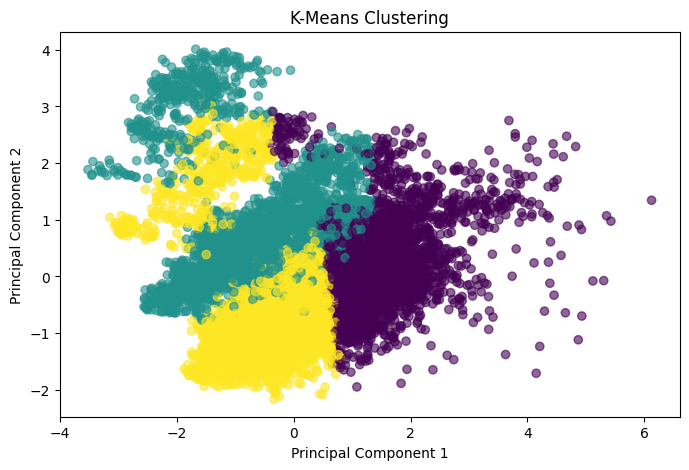

['kmeans_model.pkl']

In [56]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train_scaled)
kmeans_labels = kmeans.predict(X_test_scaled)
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.title('K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
joblib.dump(kmeans, 'kmeans_model.pkl')


#### 3. Random Forest
A Random Forest model is trained to handle non-linear relationships effectively.

In [57]:
# 3. Random Forest
rf_model = RandomForestRegressor(n_estimators=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)
print(f"Random Forest - MSE: {rf_mse}, R2: {rf_r2}")
joblib.dump(rf_model, 'rf_model.pkl')


Random Forest - MSE: 35.46150697069943, R2: 0.7722766074191769


['rf_model.pkl']

#### 4. XGBoost
XGBoost is trained for further comparison with other models.

In [58]:
xgb_model = XGBRegressor(n_estimators=10, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)
print(f"XGBoost - MSE: {xgb_mse}, R2: {xgb_r2}")
joblib.dump(xgb_model, 'xgb_model.pkl')


XGBoost - MSE: 56.61518859863281, R2: 0.6364338397979736


['xgb_model.pkl']

#### 5. Support Vector Machine (SVM)
Linear SVM is applied to explore its performance on this dataset.

In [59]:
svm_model = SVR(kernel='linear', C=0.1, epsilon=0.2)
svm_model.fit(X_train_scaled[:1000], y_train[:1000])
svm_pred = svm_model.predict(X_test_scaled[:500])
svm_mse = mean_squared_error(y_test[:500], svm_pred)
svm_r2 = r2_score(y_test[:500], svm_pred)
print(f"SVM - MSE: {svm_mse}, R2: {svm_r2}")
joblib.dump(svm_model, 'svm_model.pkl')


SVM - MSE: 147.77760139775282, R2: -0.02046702404275913


['svm_model.pkl']

#### 6. Light GBM
LightGBM, a gradient boosting model, is used to evaluate its effectiveness.

In [60]:
lgbm_model = LGBMRegressor(n_estimators=10, random_state=42)
lgbm_model.fit(X_train_scaled, y_train)
lgbm_pred = lgbm_model.predict(X_test_scaled)
lgbm_mse = mean_squared_error(y_test, lgbm_pred)
lgbm_r2 = r2_score(y_test, lgbm_pred)
print(f"Light GBM - MSE: {lgbm_mse}, R2: {lgbm_r2}")
joblib.dump(lgbm_model, 'lgbm_model.pkl')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1128
[LightGBM] [Info] Number of data points in the train set: 50780, number of used features: 7
[LightGBM] [Info] Start training from score 41.603584
Light GBM - MSE: 75.2609279481382, R2: 0.5166964039263198


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


['lgbm_model.pkl']

#### 7. Neural Network
A simple neural network model is applied for further exploration.

In [61]:
nn_model = MLPRegressor(hidden_layer_sizes=(10,), max_iter=100, random_state=42)
nn_model.fit(X_train_scaled, y_train)
nn_pred = nn_model.predict(X_test_scaled)
nn_mse = mean_squared_error(y_test, nn_pred)
nn_r2 = r2_score(y_test, nn_pred)
print(f"Neural Network - MSE: {nn_mse}, R2: {nn_r2}")
joblib.dump(nn_model, 'nn_model.pkl')


Neural Network - MSE: 127.47496451822633, R2: 0.1813931818183534


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


['nn_model.pkl']

#### 8. CatBoost Regressor
CatBoost, a gradient boosting model optimized for categorical data, is applied.

In [62]:
catboost_model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, verbose=0, random_state=42)
catboost_model.fit(X_train, y_train)
catboost_pred = catboost_model.predict(X_test)
catboost_mse = mean_squared_error(y_test, catboost_pred)
catboost_r2 = r2_score(y_test, catboost_pred)
print(f"CatBoost Regressor - MSE: {catboost_mse}, R2: {catboost_r2}")
joblib.dump(catboost_model, 'catboost_model.pkl')


CatBoost Regressor - MSE: 52.51498728232498, R2: 0.6627641607235975


['catboost_model.pkl']

### Evaluation and Comparison
#### Correlation Analysis
A heatmap is used to visualize feature correlations.

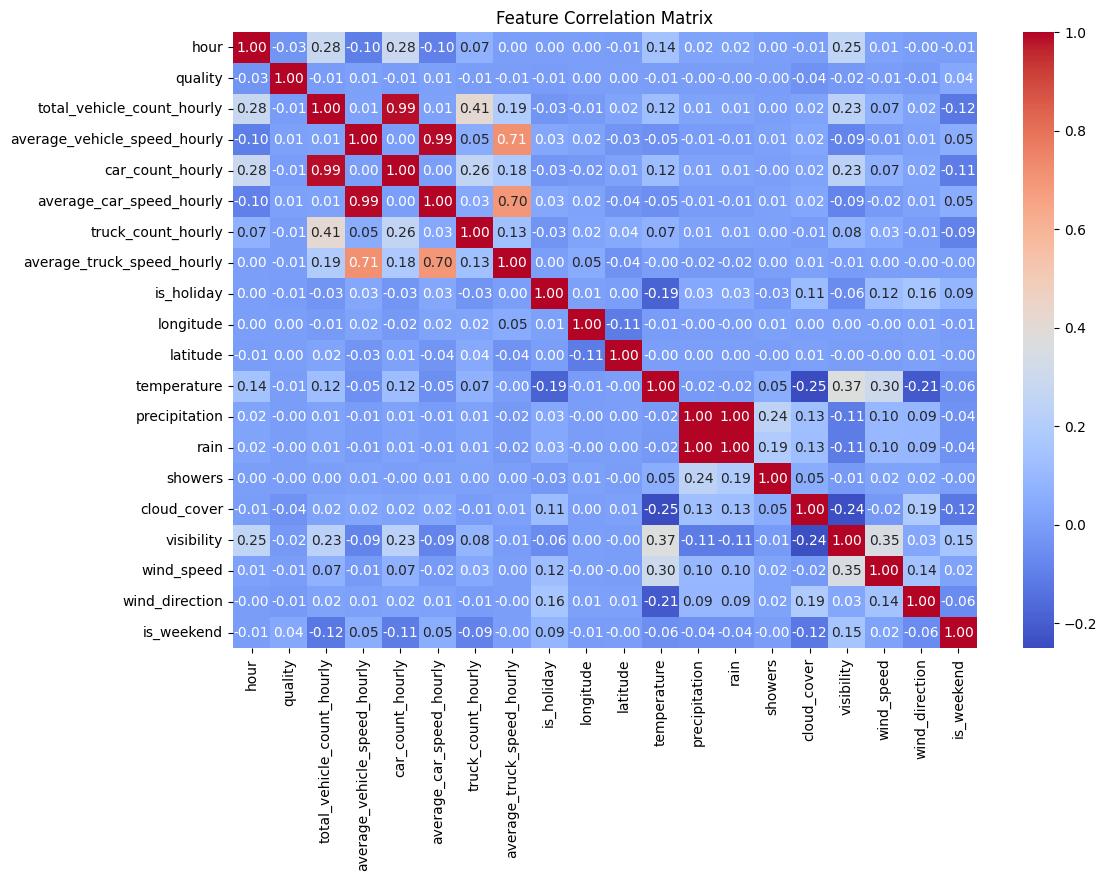

In [63]:
numeric_columns = merged_data.select_dtypes(include=[np.number])
correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


#### Spatial Analysis
Traffic speed is visualized geographically using scatter plots.

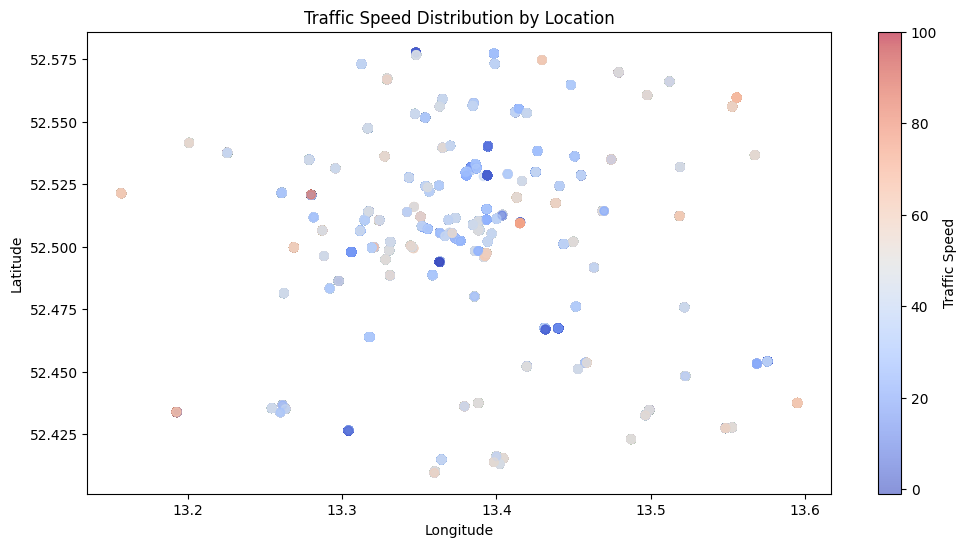

In [64]:
plt.figure(figsize=(12, 6))
mappable = plt.scatter(merged_data['longitude'], merged_data['latitude'],
                       c=merged_data['average_vehicle_speed_hourly'],
                       cmap='coolwarm', alpha=0.6)
plt.title("Traffic Speed Distribution by Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(mappable, label="Traffic Speed")
plt.show()


#### Scenario Analysis
Comparison of average speeds during holidays and non-holidays.

In [65]:
temp_holiday = merged_data[merged_data['is_holiday'] == 1]['average_vehicle_speed_hourly'].mean()
temp_non_holiday = merged_data[merged_data['is_holiday'] == 0]['average_vehicle_speed_hourly'].mean()
print(f"Average Speed on Holidays: {temp_holiday}")
print(f"Average Speed on Non-Holidays: {temp_non_holiday}")


Average Speed on Holidays: 42.98055169676523
Average Speed on Non-Holidays: 41.50059037938293


#### Model Comparison
Model performance is compared using MSE and R² values.

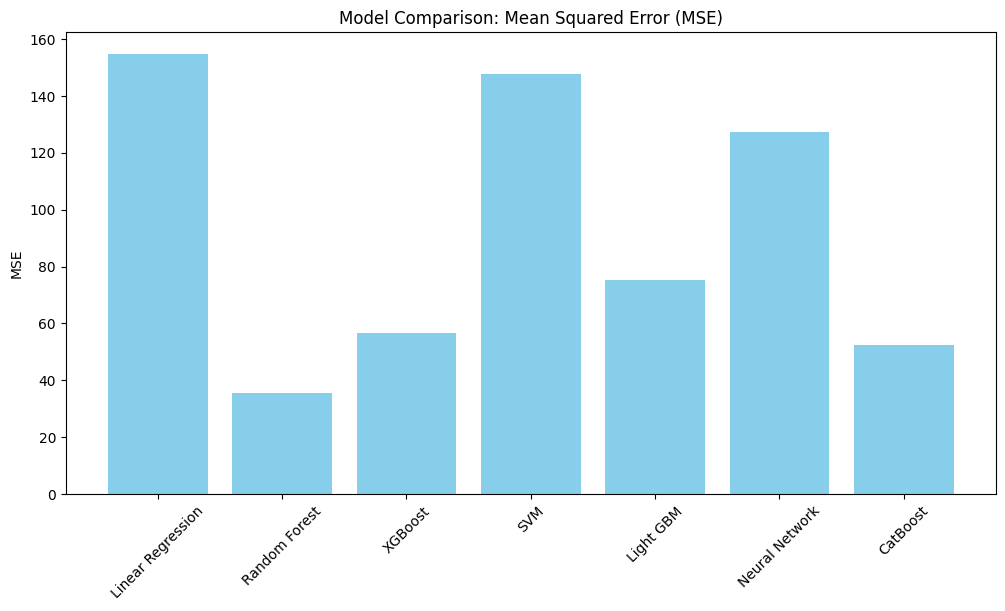

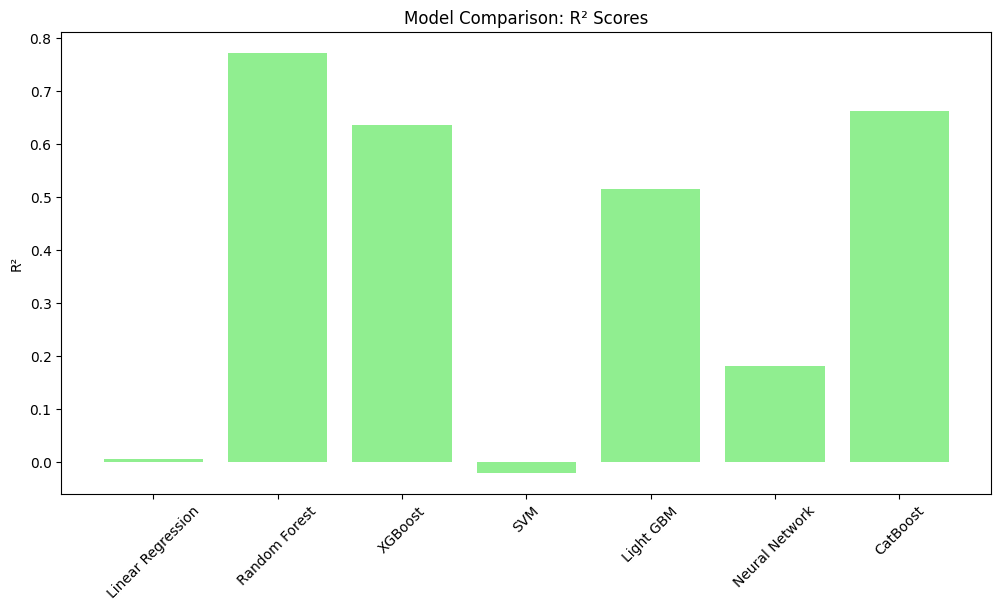

In [66]:
model_names = ["Linear Regression", "Random Forest", "XGBoost", "SVM", "Light GBM", "Neural Network", "CatBoost"]
mse_values = [lr_mse, rf_mse, xgb_mse, svm_mse, lgbm_mse, nn_mse, catboost_mse]
plt.figure(figsize=(12, 6))
plt.bar(model_names, mse_values, color='skyblue')
plt.title("Model Comparison: Mean Squared Error (MSE)")
plt.ylabel("MSE")
plt.xticks(rotation=45)
plt.show()

r2_values = [lr_r2, rf_r2, xgb_r2, svm_r2, lgbm_r2, nn_r2, catboost_r2]
plt.figure(figsize=(12, 6))
plt.bar(model_names, r2_values, color='lightgreen')
plt.title("Model Comparison: R² Scores")
plt.ylabel("R²")
plt.xticks(rotation=45)
plt.show()

### OpenRouteService API Integration
Integrate OpenRouteService API for route optimization.

In [67]:
# OpenRouteService API key
ORS_API_KEY = "5b3ce3597851110001cf624805043830a13c48ab828b57636a471155"
ors_client = openrouteservice.Client(key=ORS_API_KEY)


In [68]:
# Function to fetch route from OpenRouteService
def get_route_from_openrouteservice(start_coords, end_coords):
    route = ors_client.directions(
        coordinates=[start_coords, end_coords],
        profile='driving-car',
        format='geojson'
    )
    return route['features'][0]['geometry']['coordinates']


In [69]:
# Example usage
start_coords = (13.4050, 52.5200)  # Berlin center
end_coords = (13.4500, 52.5100)   # A point in Berlin
ors_route = get_route_from_openrouteservice(start_coords, end_coords)
print("OpenRouteService Route:", ors_route)


OpenRouteService Route: [[13.405003, 52.520002], [13.404987, 52.520013], [13.405629, 52.520343], [13.406302, 52.520698], [13.408721, 52.521911], [13.409504, 52.522309], [13.409814, 52.522449], [13.410198, 52.52265], [13.410426, 52.522787], [13.410997, 52.523147], [13.411357, 52.52337], [13.411535, 52.52348], [13.412151, 52.523893], [13.412333, 52.523864], [13.412682, 52.5237], [13.413107, 52.523506], [13.413528, 52.52331], [13.413678, 52.52324], [13.41383, 52.523169], [13.413966, 52.523106], [13.414481, 52.522865], [13.414797, 52.522721], [13.415088, 52.522584], [13.415259, 52.5225], [13.415398, 52.522436], [13.415814, 52.522245], [13.41627, 52.522028], [13.416535, 52.521894], [13.416806, 52.521811], [13.417199, 52.521693], [13.41858, 52.521275], [13.419129, 52.521108], [13.419651, 52.52095], [13.421879, 52.520276], [13.422389, 52.520122], [13.42329, 52.519849], [13.425008, 52.519326], [13.425471, 52.519186], [13.426029, 52.519018], [13.426822, 52.518809], [13.427018, 52.518732], [13.4

### Visualize Road Network and Routes
Verify edge connectivity between consecutive nodes to construct a valid route.

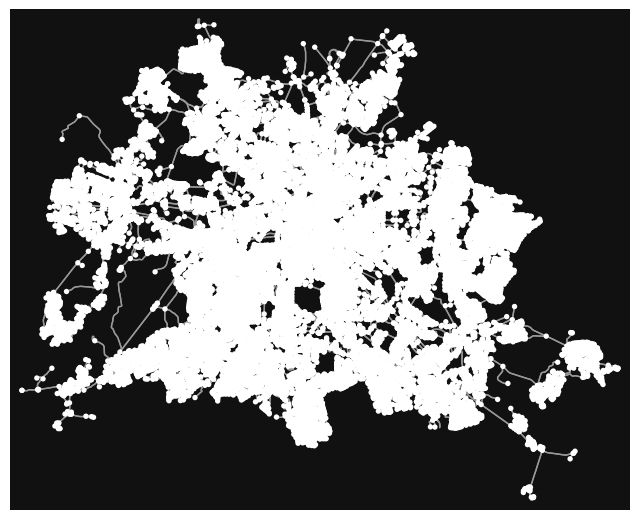

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [70]:
# Load road network for Berlin
graph = ox.graph_from_place("Berlin, Germany", network_type='drive')
ox.plot_graph(graph)


### Visualize route on the graph
Create a visualization of the road network, showing nodes as intersections and edges as road connections.

Error plotting route using ox.plot_graph_route: 'NoneType' object has no attribute 'values'
Attempting manual plotting...


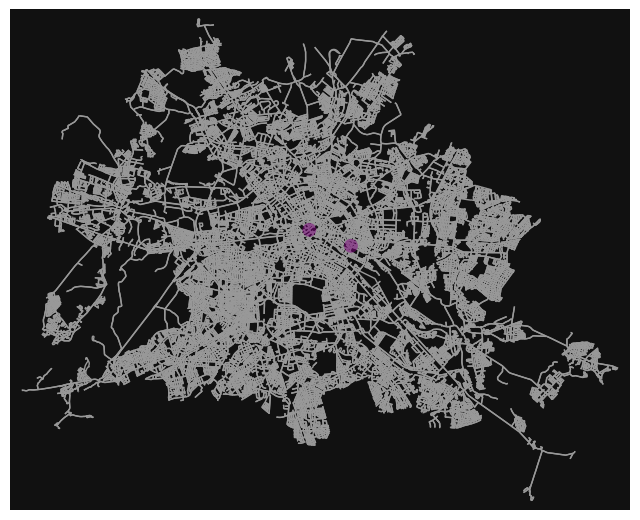

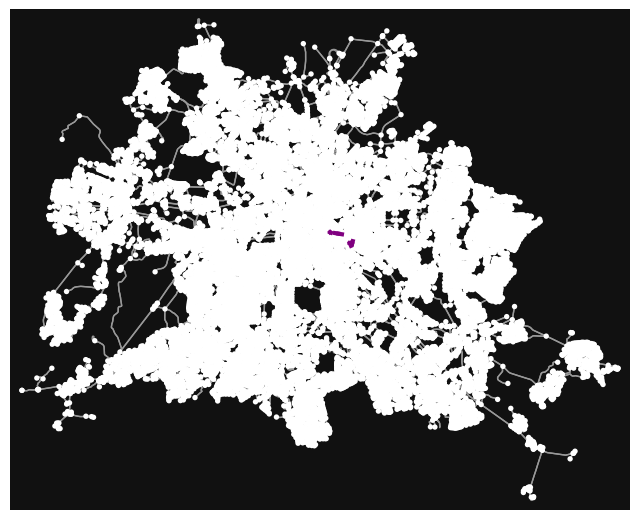

In [71]:

# Check if each coordinate is within the graph and filter invalid coordinates
valid_ors_route_nodes = []
for coord in ors_route:
    try:
        node = ox.distance.nearest_nodes(graph, coord[0], coord[1])
        valid_ors_route_nodes.append(node)
    except Exception as e:
        print(f"Skipping invalid coordinate {coord}: {e}")

# Ensure edges exist between consecutive nodes
existing_route = []
for u, v in zip(valid_ors_route_nodes[:-1], valid_ors_route_nodes[1:]):
    edge_data = graph.get_edge_data(u, v)
    if edge_data:  # Check if an edge exists
        existing_route.append(u)
if valid_ors_route_nodes[-1] not in existing_route:
    existing_route.append(valid_ors_route_nodes[-1])  # Add the last node if valid

# Manually visualize the route if ox.plot_graph_route fails
if len(existing_route) > 1:
    try:
        fig, ax = ox.plot_graph_route(graph, existing_route, route_linewidth=3, node_size=0, route_color='purple')
    except Exception as e:
        print(f"Error plotting route using ox.plot_graph_route: {e}")
        print("Attempting manual plotting...")
        fig, ax = ox.plot_graph(graph, show=False, close=False)
        for u, v in zip(existing_route[:-1], existing_route[1:]):
            if graph.has_edge(u, v):
                x = [graph.nodes[u]['x'], graph.nodes[v]['x']]
                y = [graph.nodes[u]['y'], graph.nodes[v]['y']]
                ax.plot(x, y, color='purple', linewidth=3)
        plt.show()
else:
    print("No valid route segments found in the graph.")